Després de veure els resultats dels models sense features, ara toca experimentar amb quins features i quina codificació fan que el model millori.
En aquesta versió, afegim embeddings de paraules utilitzant Word2Vec per obtenir un millor context semàntic.

In [9]:
#%pip install gensim

In [15]:
import nltk
import re
import unicodedata
import numpy as np
from nltk.tag import CRFTagger
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report

nltk.download('conll2002')
nltk.download('stopwords')
from nltk.corpus import conll2002, stopwords

tr_sp = conll2002.iob_sents('esp.train') # Train Español
dev_sp = conll2002.iob_sents('esp.testa') # Dev Español
test_sp = conll2002.iob_sents('esp.testb') # Test Español

stop_words = set(stopwords.words('spanish'))

# Cargar el modelo de embeddings, aquí usamos Word2Vec preentrenado
print("Cargando modelo de Word2Vec...")
word2vec_model = KeyedVectors.load_word2vec_format('model_esp.bin', binary=True) 
print("Modelo cargado correctamente!")

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cargando modelo de Word2Vec...
Modelo cargado correctamente!


In [16]:
# Transformar los datos: dejar solo (palabra, NER)
train_sents = [[(word, ner) for word, pos, ner in sent] for sent in tr_sp]
test_sents = [[(word, ner) for word, pos, ner in sent] for sent in test_sp]

In [17]:
def features(tokens, idx):
    """
    Extrae características de una palabra, incluyendo:
        - Capitalización
        - Prefijos y sufijos
        - Tokens anteriores y posteriores
        - Embedding de palabra utilizando Word2Vec
    """
    pattern = re.compile(r"\d")
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalización
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Número
    if re.search(pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Puntuación
    punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Prefijos y sufijos
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
        feature_list.append("PREF_" + token[:1])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
        feature_list.append("PREF_" + token[:2])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        feature_list.append("PREF_" + token[:3])

    # Palabra anterior
    if idx > 0:
        prev_token = tokens[idx - 1]
        feature_list.append("PREV_WORD_" + prev_token)
    else:
        feature_list.append("BOS")  # Inicio de oración

    # Palabra siguiente
    if idx < len(tokens) - 1:
        next_token = tokens[idx + 1]
        feature_list.append("NEXT_WORD_" + next_token)
    else:
        feature_list.append("EOS")  # Fin de oración

    # Embedding de palabra utilizando Word2Vec
    try:
        embedding_vector = word2vec_model[token.lower()]
        # Añadimos los primeros 10 valores del embedding como características
        for i, value in enumerate(embedding_vector[:10]):
            feature_list.append(f"EMBEDDING_DIM_{i}_{value:.4f}")
    except KeyError:
        feature_list.append("UNK_EMBEDDING")  # Palabra desconocida

    feature_list.append("WORD_" + token)

    return feature_list

In [18]:
ct = nltk.tag.CRFTagger(feature_func=features)
ct.train(train_sents, 'esp_model.crf.tagger')
ct.set_model_file('esp_model.crf.tagger')

In [19]:
predicted_sents = ct.tag_sents([ [word for word, tag in sent] for sent in test_sents ])

In [26]:
# Accuracy a nivel de entidades, reemplazado por F1-Score
from sklearn.metrics import classification_report,f1_score

true_entities = []
predicted_entities = []

for true_sent, pred_sent in zip(test_sents, predicted_sents):
    for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
        if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)
        elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)

# Calcular el F1 score (weighted)
f1 = f1_score(true_entities, predicted_entities, average='weighted', zero_division=0)
print(f"F1 Score (weighted) sobre entidades: {f1:.2%}")

# També fem un report del reconeixament
print("\nReporte por clase:")
print(classification_report(true_entities, predicted_entities, zero_division=0))

F1 Score (weighted) sobre entidades: 77.99%

Reporte por clase:
              precision    recall  f1-score   support

       B-LOC       0.83      0.78      0.81      1084
      B-MISC       0.72      0.53      0.61       339
       B-ORG       0.83      0.86      0.84      1400
       B-PER       0.85      0.87      0.86       735
       I-LOC       0.75      0.65      0.70       325
      I-MISC       0.66      0.56      0.60       557
       I-ORG       0.83      0.82      0.83      1104
       I-PER       0.91      0.95      0.93       634
           O       0.00      0.00      0.00       171

    accuracy                           0.77      6349
   macro avg       0.71      0.67      0.69      6349
weighted avg       0.79      0.77      0.78      6349



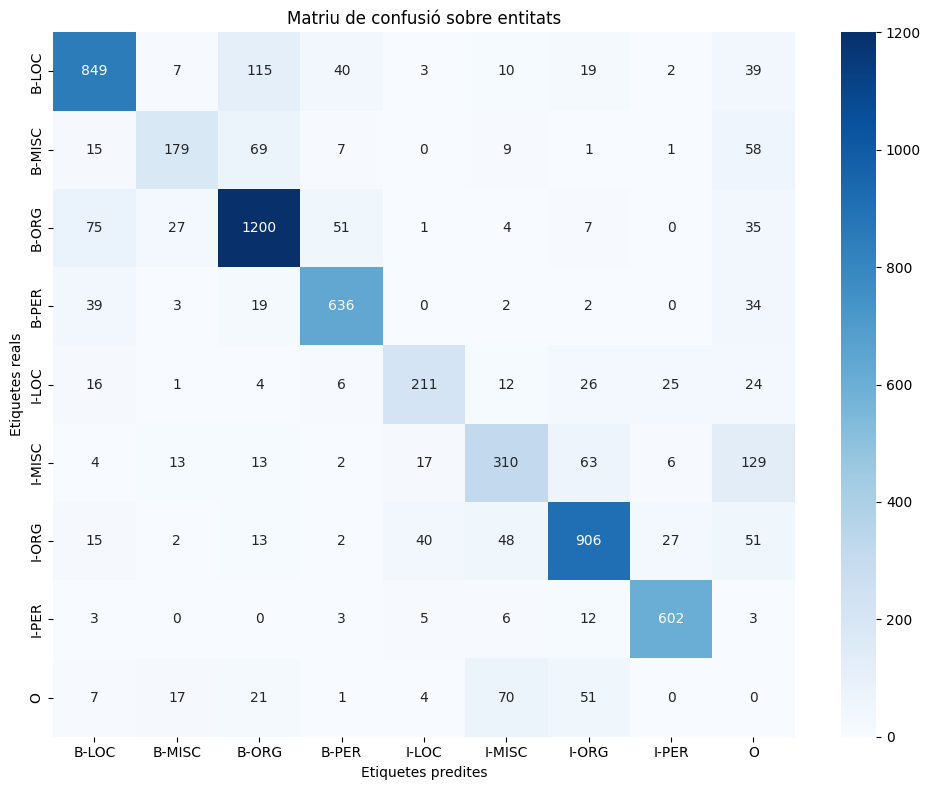

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetes predites')
plt.ylabel('Etiquetes reals')
plt.title('Matriu de confusió sobre entitats')
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
from sklearn.metrics import confusion_matrix

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

resultats = []
for i, label in enumerate(labels):
    correctes = cm[i, i]
    prediccions_totals = sum(cm[:, i])  # total de vegades que es va predir aquesta etiqueta
    errors = prediccions_totals - correctes
    percentatge = (correctes / prediccions_totals * 100) if prediccions_totals > 0 else 0.0
    resultats.append({
        'Etiqueta': label,
        'Correctes': correctes,
        'Errors': errors,
        '% d\'encerts': f"{percentatge:.2f}%"
    })

df_resultats = pd.DataFrame(resultats)
print(df_resultats)

  Etiqueta  Correctes  Errors % d'encerts
0    B-LOC        849     174      82.99%
1   B-MISC        179      70      71.89%
2    B-ORG       1200     254      82.53%
3    B-PER        636     112      85.03%
4    I-LOC        211      70      75.09%
5   I-MISC        310     161      65.82%
6    I-ORG        906     181      83.35%
7    I-PER        602      61      90.80%
8        O          0     373       0.00%
